## Analyzing and comparing the performance of differently clustered datasets for Task 1

### 1. Import relevant libraries

In [1]:
import pandas as pd
from utils.pre_processing_task_1 import PreProcessingTask1 as pp
import utils.aa_one_hot_encoding as ohe
import numpy as np
from protlearn import features
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import utils.cross_validation as cv
import torch

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/protlearn/features/aaindex1.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### 2. Load datasets

In [2]:
df30 = pd.read_csv('datasets/clustered/exp_proteins_clustered_30.tsv', sep='\t')
df50 = pd.read_csv('datasets/clustered/exp_proteins_clustered_50.tsv', sep='\t')
df70 = pd.read_csv('datasets/clustered/exp_proteins_clustered_70.tsv', sep='\t')
df90 = pd.read_csv('datasets/clustered/exp_proteins_clustered_90.tsv', sep='\t')
df100 = pd.read_csv('datasets/clustered/exp_proteins_clustered_100.tsv', sep='\t')

### 3. Curate data

#### 3.1 Filter lengths

In [3]:
# Define Percentiles
p1 = 25
p2 = 75

df30 = pp.filter_lengths(df30, p1, p2)
df50 = pp.filter_lengths(df50, p1, p2)
df70 = pp.filter_lengths(df70, p1, p2)
df90 = pp.filter_lengths(df90, p1, p2)
df100 = pp.filter_lengths(df100, p1, p2)

#### 3.2 Undersample

In [4]:
df30 = pp.undersample(df30)
df50 = pp.undersample(df50)
df70 = pp.undersample(df70)
df90 = pp.undersample(df90)
df100 = pp.undersample(df100)

### 4. Initial dataset statistics

#### 4.1 Class distributions

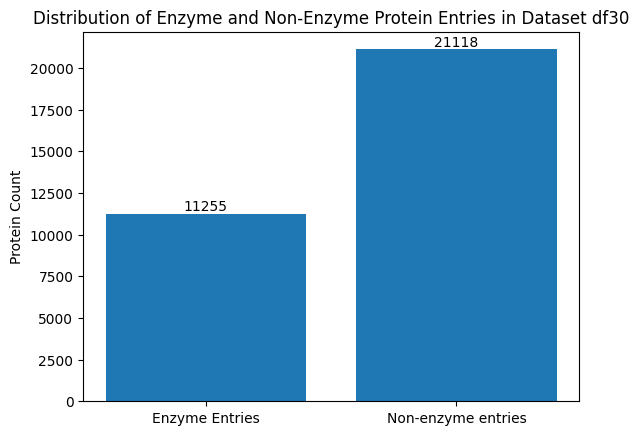

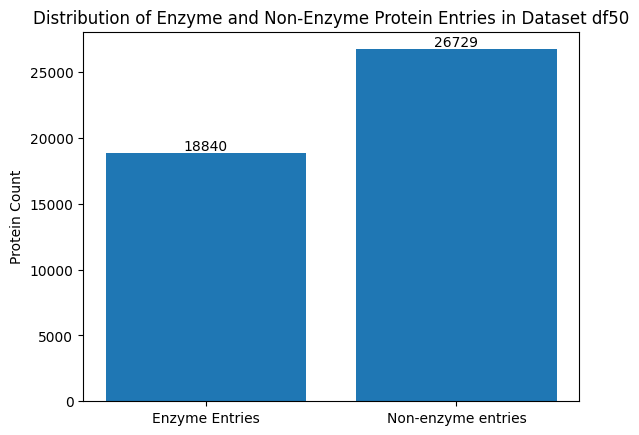

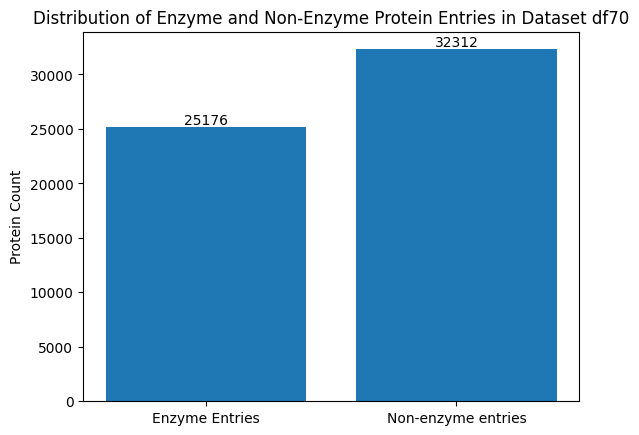

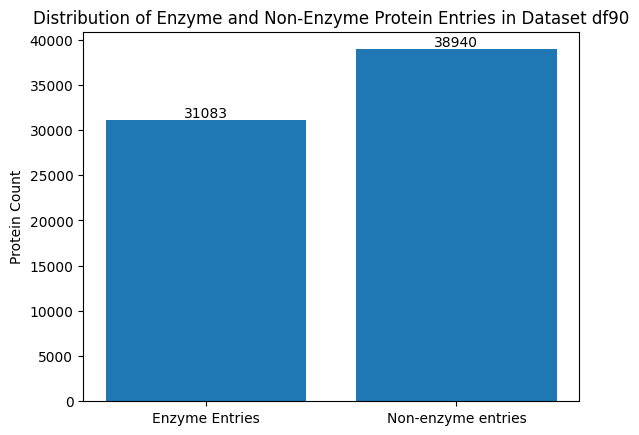

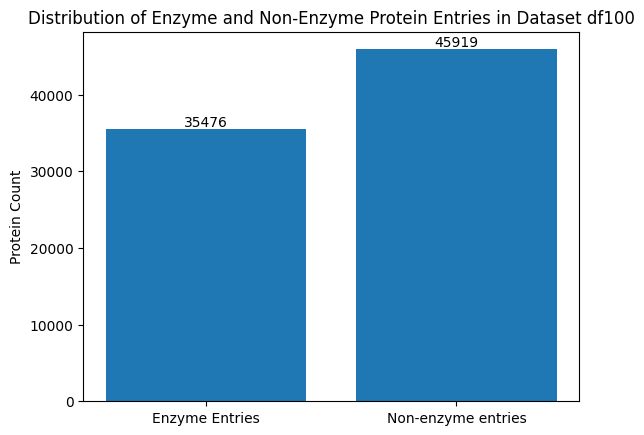

In [15]:
pp.class_distribution(df30, 'df30')
pp.class_distribution(df50, 'df50')
pp.class_distribution(df70, 'df70')
pp.class_distribution(df90, 'df90')
pp.class_distribution(df100, 'df100')

#### 4.2 Length distributions

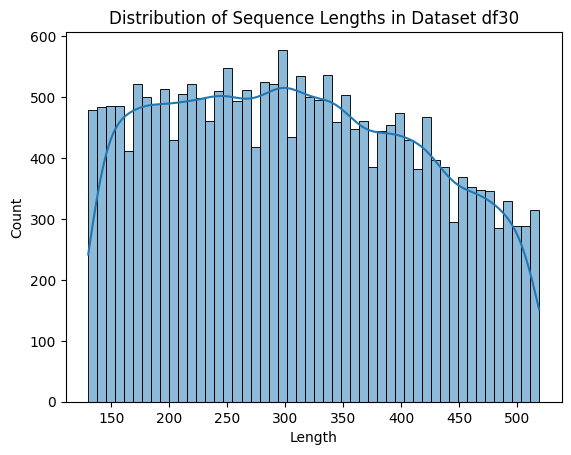

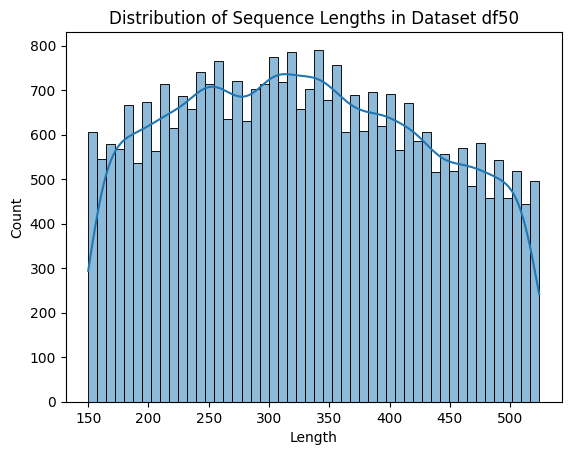

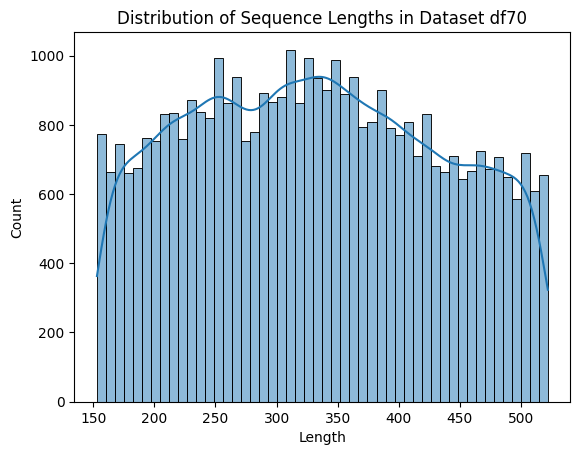

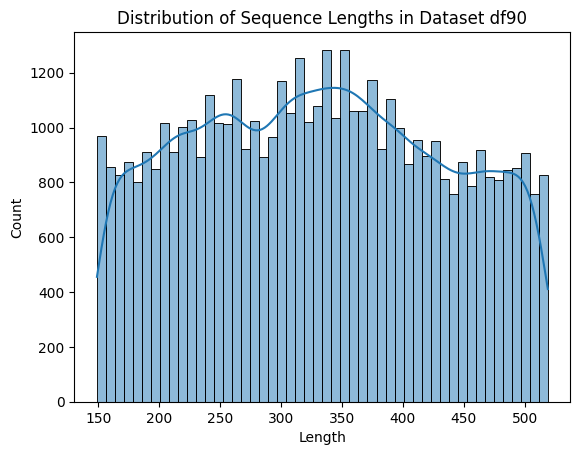

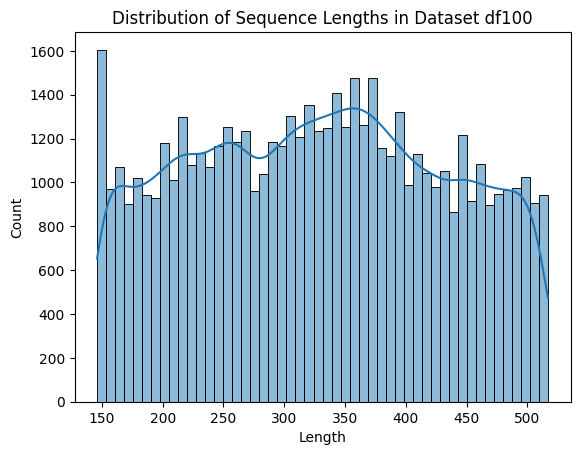

In [22]:
pp.length_distribution(df30, 'df30')
pp.length_distribution(df50, 'df50')
pp.length_distribution(df70, 'df70')
pp.length_distribution(df90, 'df90')
pp.length_distribution(df100, 'df100')

#### 4.3 Dataset Sizes

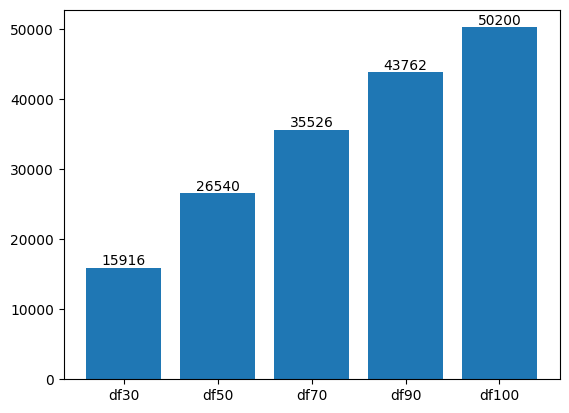

In [5]:
len_dict = {'df30' : len(df30), 'df50' : len(df50), 'df70' : len(df70), 'df90' : len(df90), 'df100' : len(df100)}
X = list(len_dict.keys())
y = list(len_dict.values())
bars = plt.bar(X, y)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom')
plt.show()

### 5. Extract sequences and labels

In [63]:
X_30 = list(df30['Sequence'])
y_30 = list(df30['Enzyme'])

X_50 = list(df50['Sequence'])
y_50 = list(df50['Enzyme'])

X_70 = list(df70['Sequence'])
y_70 = list(df70['Enzyme'])

X_90 = list(df90['Sequence'])
y_90 = list(df90['Enzyme'])

X_100 = list(df100['Sequence'])
y_100 = list(df100['Enzyme'])

In [8]:
class Task1Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
dataset30 = Task1Dataset(X_30, y_30)
dataset50 = Task1Dataset(X_50, y_50)
dataset70 = Task1Dataset(X_70, y_70)
dataset90 = Task1Dataset(X_90, y_90)
dataset100 = Task1Dataset(X_100, y_100)

### 6. Feature extraction

#### 6.1 One-Hot-Encoding

#### 6.2 AAIndex Encoding

In [64]:
X_30_aaindex = features.aaindex1(X_30, standardize='zscore')[0]
X_50_aaindex = features.aaindex1(X_50, standardize='zscore')[0]
X_70_aaindex = features.aaindex1(X_70, standardize='zscore')[0]
X_90_aaindex = features.aaindex1(X_90, standardize='zscore')[0]
X_100_aaindex = features.aaindex1(X_100, standardize='zscore')[0]

#### 6.3 ProtT5 Embeddings

#### 6.4 Construct PyTorch Datasets

In [65]:
class Task1Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(dim=1)
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [66]:
dataset30 = Task1Dataset(X_30_aaindex, y_30)
dataset50 = Task1Dataset(X_50_aaindex, y_50)
dataset70 = Task1Dataset(X_70_aaindex, y_70)
dataset90 = Task1Dataset(X_90_aaindex, y_90)
dataset100 = Task1Dataset(X_100_aaindex, y_100)

### 7. Model Selection

#### 7.1 Random Forest

In [30]:
rf = RandomForestClassifier()

#### 7.2 Neural Network

##### 7.2.1 Model 1

In [67]:
class Task1ModelAAIndex1(nn.Module):
    def __init__(self):
        super().__init__()
        self.le_relu = nn.LeakyReLU()
        self.hidden_layer_1 = nn.Linear(553, 369, dtype=torch.float32)
        self.dropout = nn.Dropout(0.5)
        self.hidden_layer_2 = nn.Linear(369, 128, dtype=torch.float32)
        self.output_layer = nn.Linear(128, 1, dtype=torch.float32)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        h1 = self.le_relu(self.hidden_layer_1(x))
        d1 = self.dropout(h1)
        h2 = self.le_relu(self.hidden_layer_2(d1))
        return self.sigmoid(self.output_layer(h2))

### 8. Cross Validation

#### 8.1 Random Forest

In [31]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=523)
cv_30 = cross_val_score(rf, X_30_aaindex, y_30, cv=skfold, scoring='accuracy')
cv_50 = cross_val_score(rf, X_50_aaindex, y_50, cv=skfold, scoring='accuracy')
cv_70 = cross_val_score(rf, X_70_aaindex, y_70, cv=skfold, scoring='accuracy')
cv_90 = cross_val_score(rf, X_90_aaindex, y_90, cv=skfold, scoring='accuracy')
cv_100 = cross_val_score(rf, X_100_aaindex, y_100, cv=skfold, scoring='accuracy')

 Results: It seems that the cross-val-accuracy increases the higher the clustering threshold. This however, could be caused by the larger dataset sizes 

In [32]:
results = pd.DataFrame([
    {"threshold": 30, "mean_acc": cv_30.mean(), "std_acc": cv_30.std(), 'dataset_size': len(df30)},
    {"threshold": 50, "mean_acc": cv_50.mean(), "std_acc": cv_50.std(), 'dataset_size': len(df50)},
    {"threshold": 70, "mean_acc": cv_70.mean(), "std_acc": cv_70.std(), 'dataset_size': len(df70)},
    {"threshold": 90, "mean_acc": cv_90.mean(), "std_acc": cv_90.std(), 'dataset_size': len(df90)},
    {"threshold": 100, "mean_acc": cv_100.mean(), "std_acc": cv_100.std(), 'dataset_size': len(df100)}
])
results.to_csv('performance_eval/eval_results/cluster_thresh_aaindex_rf_cv_comparison_filter_lens_10-90_undersampled.tsv', sep='\t')

#### 8.2 Neural Network

##### 8.2.1 SGD, BCELoss, lr = 0.01, epochs = 100

In [68]:
criterion = nn.BCELoss()

Fold 1
Train loss: 0.5843, Validation loss: 0.5358, Validation acc: 0.7280
Train loss: 0.5276, Validation loss: 0.5212, Validation acc: 0.7443
Train loss: 0.5182, Validation loss: 0.5122, Validation acc: 0.7478
Train loss: 0.5080, Validation loss: 0.5119, Validation acc: 0.7450
Train loss: 0.5069, Validation loss: 0.5072, Validation acc: 0.7538
Train loss: 0.5003, Validation loss: 0.5040, Validation acc: 0.7500
Train loss: 0.4979, Validation loss: 0.5014, Validation acc: 0.7594
Train loss: 0.4977, Validation loss: 0.5036, Validation acc: 0.7572
Train loss: 0.4925, Validation loss: 0.4987, Validation acc: 0.7579
Train loss: 0.4903, Validation loss: 0.4965, Validation acc: 0.7535
Train loss: 0.4889, Validation loss: 0.4952, Validation acc: 0.7601
Train loss: 0.4879, Validation loss: 0.4942, Validation acc: 0.7629
Train loss: 0.4854, Validation loss: 0.4944, Validation acc: 0.7601
Train loss: 0.4840, Validation loss: 0.4915, Validation acc: 0.7610
Train loss: 0.4864, Validation loss: 0.49

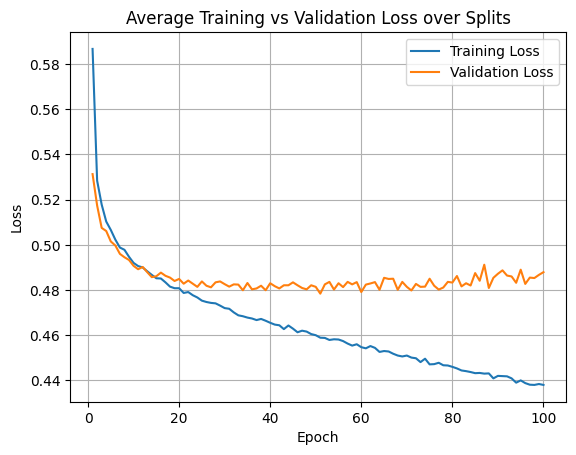

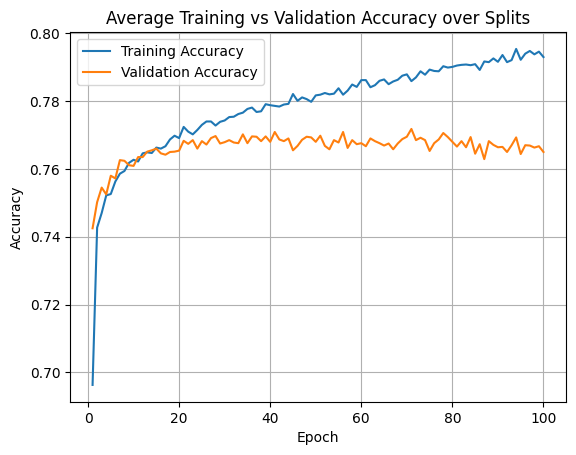

5 [[np.float64(0.7648), 1309.0, 466.0, 283.0, 1126.0], [np.float64(0.7757), 1292.0, 415.0, 299.0, 1177.0], [np.float64(0.7619), 1287.0, 454.0, 304.0, 1138.0], [np.float64(0.7707), 1366.0, 504.0, 226.0, 1087.0], [np.float64(0.7518), 1319.0, 517.0, 273.0, 1074.0]]
Fold 1
Train loss: 0.5471, Validation loss: 0.4834, Validation acc: 0.7687
Train loss: 0.4935, Validation loss: 0.4723, Validation acc: 0.7769
Train loss: 0.4856, Validation loss: 0.4654, Validation acc: 0.7752
Train loss: 0.4789, Validation loss: 0.4675, Validation acc: 0.7747
Train loss: 0.4746, Validation loss: 0.4682, Validation acc: 0.7766
Train loss: 0.4706, Validation loss: 0.4601, Validation acc: 0.7830
Train loss: 0.4686, Validation loss: 0.4539, Validation acc: 0.7830
Train loss: 0.4659, Validation loss: 0.4543, Validation acc: 0.7835
Train loss: 0.4629, Validation loss: 0.4505, Validation acc: 0.7873
Train loss: 0.4606, Validation loss: 0.4540, Validation acc: 0.7847
Train loss: 0.4616, Validation loss: 0.4493, Valid

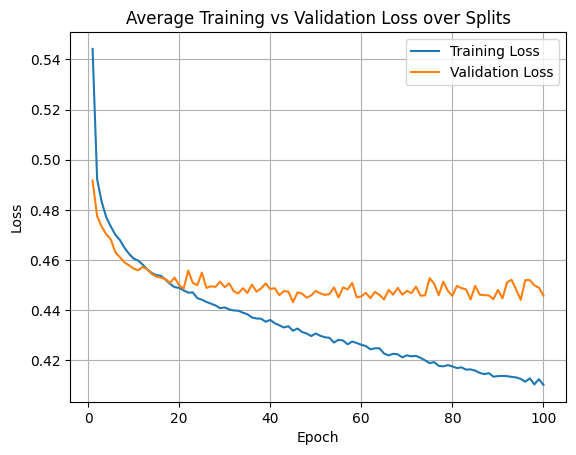

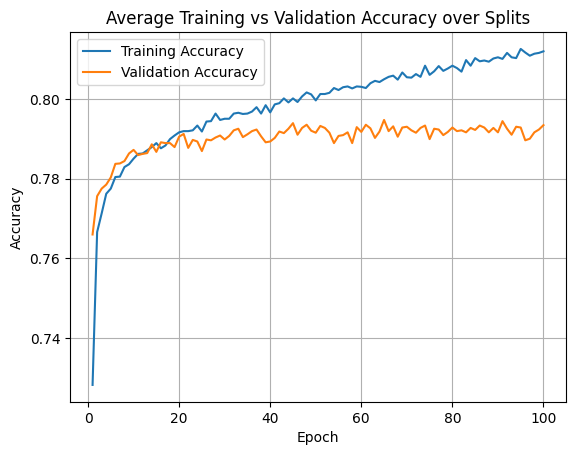

5 [[np.float64(0.793), 2266.0, 711.0, 388.0, 1943.0], [np.float64(0.7877), 2143.0, 616.0, 511.0, 2038.0], [np.float64(0.793), 2199.0, 644.0, 455.0, 2010.0], [np.float64(0.7963), 2255.0, 682.0, 399.0, 1972.0], [np.float64(0.7971), 2222.0, 645.0, 432.0, 2009.0]]
Fold 1
Train loss: 0.5286, Validation loss: 0.4842, Validation acc: 0.7731
Train loss: 0.4835, Validation loss: 0.4731, Validation acc: 0.7788
Train loss: 0.4719, Validation loss: 0.4701, Validation acc: 0.7815
Train loss: 0.4653, Validation loss: 0.4595, Validation acc: 0.7855
Train loss: 0.4625, Validation loss: 0.4531, Validation acc: 0.7910
Train loss: 0.4601, Validation loss: 0.4537, Validation acc: 0.7895
Train loss: 0.4564, Validation loss: 0.4492, Validation acc: 0.7938
Train loss: 0.4542, Validation loss: 0.4514, Validation acc: 0.7958
Train loss: 0.4536, Validation loss: 0.4641, Validation acc: 0.7843
Train loss: 0.4517, Validation loss: 0.4418, Validation acc: 0.7952
Train loss: 0.4488, Validation loss: 0.4386, Validat

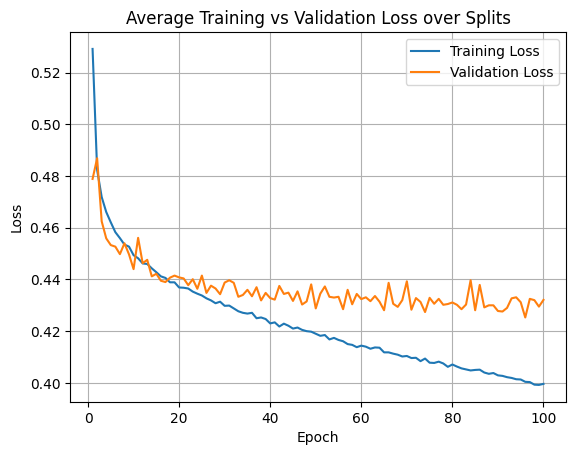

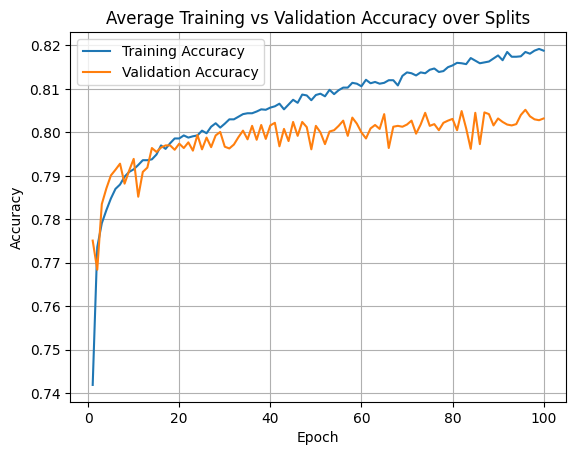

5 [[np.float64(0.8103), 2949.0, 744.0, 604.0, 2809.0], [np.float64(0.7956), 3127.0, 1027.0, 425.0, 2526.0], [np.float64(0.8113), 2965.0, 754.0, 587.0, 2799.0], [np.float64(0.7994), 2952.0, 824.0, 601.0, 2728.0], [np.float64(0.7992), 3113.0, 987.0, 440.0, 2565.0]]
Fold 1
Train loss: 0.5220, Validation loss: 0.4693, Validation acc: 0.7771
Train loss: 0.4785, Validation loss: 0.4580, Validation acc: 0.7816
Train loss: 0.4687, Validation loss: 0.4607, Validation acc: 0.7888
Train loss: 0.4607, Validation loss: 0.4431, Validation acc: 0.7925
Train loss: 0.4566, Validation loss: 0.4394, Validation acc: 0.7940
Train loss: 0.4532, Validation loss: 0.4506, Validation acc: 0.7897
Train loss: 0.4527, Validation loss: 0.4318, Validation acc: 0.7968
Train loss: 0.4489, Validation loss: 0.4336, Validation acc: 0.7981
Train loss: 0.4466, Validation loss: 0.4461, Validation acc: 0.7900
Train loss: 0.4455, Validation loss: 0.4907, Validation acc: 0.7641
Train loss: 0.4443, Validation loss: 0.4274, Vali

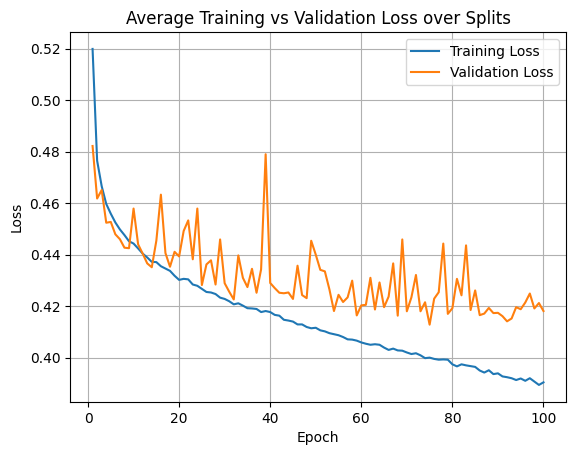

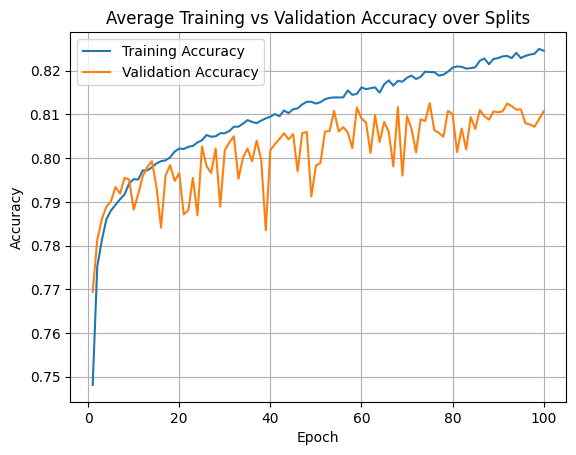

5 [[np.float64(0.8125), 3811.0, 1076.0, 565.0, 3301.0], [np.float64(0.8157), 3746.0, 982.0, 631.0, 3394.0], [np.float64(0.8034), 3784.0, 1129.0, 592.0, 3247.0], [np.float64(0.8078), 3943.0, 1249.0, 433.0, 3127.0], [np.float64(0.8139), 3771.0, 1024.0, 605.0, 3352.0]]
Fold 1
Train loss: 0.5147, Validation loss: 0.4727, Validation acc: 0.7747
Train loss: 0.4728, Validation loss: 0.4553, Validation acc: 0.7870
Train loss: 0.4636, Validation loss: 0.4489, Validation acc: 0.7914
Train loss: 0.4553, Validation loss: 0.4475, Validation acc: 0.7925
Train loss: 0.4521, Validation loss: 0.4420, Validation acc: 0.7966
Train loss: 0.4461, Validation loss: 0.4370, Validation acc: 0.8012
Train loss: 0.4434, Validation loss: 0.4332, Validation acc: 0.7995
Train loss: 0.4405, Validation loss: 0.4364, Validation acc: 0.7954
Train loss: 0.4378, Validation loss: 0.4306, Validation acc: 0.8011
Train loss: 0.4354, Validation loss: 0.4291, Validation acc: 0.8044
Train loss: 0.4339, Validation loss: 0.4304, V

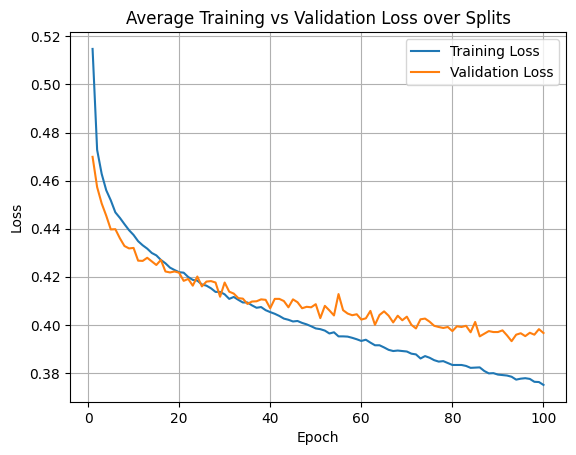

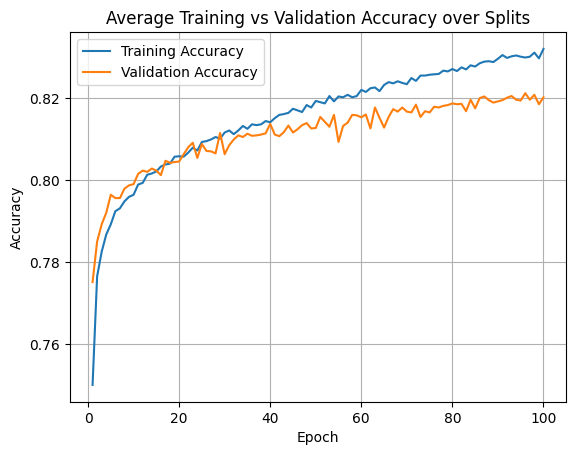

5 [[np.float64(0.8231), 4145.0, 901.0, 875.0, 4119.0], [np.float64(0.8177), 4310.0, 1120.0, 710.0, 3900.0], [np.float64(0.8244), 4358.0, 1101.0, 662.0, 3919.0], [np.float64(0.816), 4401.0, 1228.0, 619.0, 3792.0], [np.float64(0.8197), 4421.0, 1211.0, 599.0, 3809.0]]


In [69]:
cv_30 = cv.cross_validate(Task1ModelAAIndex1, dataset30, optim.SGD, criterion, 5, 32, 0.02, 100)
cv_50 = cv.cross_validate(Task1ModelAAIndex1, dataset50, optim.SGD, criterion, 5, 32, 0.02, 100)
cv_70 = cv.cross_validate(Task1ModelAAIndex1, dataset70, optim.SGD, criterion, 5, 32, 0.02, 100)
cv_90 = cv.cross_validate(Task1ModelAAIndex1, dataset90, optim.SGD, criterion, 5, 32, 0.02, 100)
cv_100 = cv.cross_validate(Task1ModelAAIndex1, dataset100, optim.SGD, criterion, 5, 32, 0.02, 100)

In [70]:
results = pd.DataFrame([
    {"threshold": 30, "mean_acc": cv_30[:, 0].mean(), "std_acc": cv_30[:, 0].std(), 'dataset_size': len(df30)},
    {"threshold": 50, "mean_acc": cv_50[:, 0].mean(), "std_acc": cv_50[:, 0].std(), 'dataset_size': len(df50)},
    {"threshold": 70, "mean_acc": cv_70[:, 0].mean(), "std_acc": cv_70[:, 0].std(), 'dataset_size': len(df70)},
    {"threshold": 90, "mean_acc": cv_90[:, 0].mean(), "std_acc": cv_90[:, 0].std(), 'dataset_size': len(df90)},
    {"threshold": 100, "mean_acc": cv_100[:, 0].mean(), "std_acc": cv_100[:, 0].std(), 'dataset_size': len(df100)}
])
results.to_csv('performance_eval/eval_results/cluster_thresh_aaindex_nn_model1_SGD_BCELoss_lr002_e100_cv_comparison_filter_lens_25-75_undersampled_.tsv', sep='\t')